# Coursework2: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

A PDF version of this notebook is also provided in case the figures do not render correctly.

**The deadline for submission is 19:00, Thu 14th February, 2019**

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

    100% |████████████████████████████████| 2.0MB 14.8MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution and max pooling operation. 

### YOUR TASK

- implement the forward pass for Conv2D and MaxPool2D
- You can only fill in the parts which are specified as "YOUR CODE HERE"
- You are **NOT** allowed to use the torch.nn module and the conv2d/maxpooling functions in torch.nn.functional

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F



In [0]:
class Conv2D(nn.Module):
    
    def __init__(self, inchannel, outchannel, kernel_size, stride, padding, bias = True):
        
        super(Conv2D, self).__init__()
        
        self.inchannel = inchannel
        self.outchannel = outchannel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.weights = nn.Parameter(torch.Tensor(outchannel, inchannel, 
                                                 kernel_size, kernel_size))
        self.weights.data.normal_(-0.1, 0.1)
        
        if bias:
            self.bias = nn.Parameter(torch.Tensor(outchannel, ))
            self.bias.data.normal_(-0.1, 0.1)
        else:
            self.bias = None
            
        
    def forward(self, x):
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
        n_filters, c_filter, h_filter, w_filter = self.weights.size()
        n, c, h, w = x.size()
        h_out = (h + 2*self.padding - h_filter)//self.stride+ 1
        w_out = (w + 2*self.padding - w_filter)//self.stride + 1
        h_out, w_out = int(h_out), int(w_out)
        x_padded = F.pad(x, (self.padding, self.padding, self.padding, self.padding,0, 0, 0, 0), mode='constant')
        i0 = torch.arange(h_filter).reshape(h_filter,1).repeat(1,w_filter).view(-1).repeat(c)
        i1 = self.stride * torch.arange(h_out).reshape(h_out,1).repeat(1,w_out).view(-1)
        j0 = torch.arange(w_filter).repeat(h_filter *c)
        j1 = self.stride * torch.arange(w_out).repeat(h_out)
        i = (i0.reshape(-1, 1) + i1.reshape(1, -1)).long()
        j = (j0.reshape(-1, 1) + j1.reshape(1, -1)).long()
        k = (torch.arange(c)).repeat(h_filter * w_filter).reshape(-1, 1).long()
        x_col = x_padded[:, k, i, j]
        x_col = x_col.transpose(1,0).transpose(2,1).reshape(h_filter * w_filter * c, -1)
        W_col = self.weights.reshape(n_filters, -1)

        if self.bias is None:
            output = W_col @ x_col
        else:
            output = W_col @ x_col + self.bias
        output = output.reshape(n_filters, h_out, w_out, n)
        output = output.transpose(3,0).transpose(3,1).transpose(3,2)
        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
        

        return output
        

In [0]:
class MaxPool2D(nn.Module):
    
    def __init__(self, pooling_size):
        # assume pooling_size = kernel_size = stride
        
        super(MaxPool2D, self).__init__()
        
        self.pooling_size = pooling_size
        

    def forward(self, x):
        
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################

        
        n, d, h, w = x.size()
        h_out = (h -self.pooling_size)/ self.pooling_size  + 1
        w_out = (w - self.pooling_size) / self.pooling_size+ 1
        h_out, w_out = int(h_out), int(w_out)

        X_reshaped = x.reshape(n * d, 1, h, w)
        x_padded = F.pad(X_reshaped, (0, 0, 0, 0, 0, 0, 0, 0), mode='constant')
        i0 = torch.arange(self.pooling_size).reshape(self.pooling_size,1).repeat(1,self.pooling_size).view(-1).repeat(1)
        i1 = self.pooling_size * torch.arange(w_out).reshape(h_out,1).repeat(1,w_out).view(-1)
        j0 = torch.arange(self.pooling_size).repeat(self.pooling_size)
        j1 =self.pooling_size * torch.arange(w_out).repeat(h_out)
        i = (i0.reshape(-1, 1) + i1.reshape(1, -1)).long()
        j = (j0.reshape(-1, 1) + j1.reshape(1, -1)).long()
        k = (torch.arange(1)).repeat(self.pooling_size * self.pooling_size).reshape(-1, 1).long()
        x_col = x_padded[:, k, i, j]
        x_col = x_col.transpose(1,0).transpose(2,1).reshape(self.pooling_size * self.pooling_size * 1, -1)
        
        values, max_idx = x_col.max(0)
        
        output = x_col[max_idx, range(max_idx.numel())]
        output = output.reshape(h_out, w_out, n, d)
        output = output.transpose(2,0).transpose(3,1)
        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
               
        return output
        

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2D(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2D(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2D(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


In [0]:
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2D(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2D(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

## Part 2 (40 points)

In this part, you will train the ResNet-18 defined in the previous part on the CIFAR-10 dataset. Code for loading the dataset, training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimiser

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

**YOUR ANSWER FOR 2.4 HERE**

A:

In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T


transform = T.ToTensor()



# load data

NUM_TRAIN = 49000
print_every = 100


data_dir = './data'
cifar10_train = dset.CIFAR10(data_dir, train=True, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(data_dir, train=True, download=True, transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)


USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))


def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
# 
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                check_accuracy(loader_val, model)
#                 print()

In [0]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        super(ResidualBlock, self).__init__() 
        self.left = nn.Sequential( nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel) ) 
        self.shortcut = nn.Sequential() 
        if stride != 1 or inchannel != outchannel: 
            self.shortcut = nn.Sequential( nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
    def forward(self, x): 
        out = self.left(x) 
        out += self.shortcut(x) 
        out = F.relu(out) 
        return out 

class ResNet(nn.Module): 
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__() 
        self.inchannel = 64 
        self.conv1 = nn.Sequential( nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False), 
                                   nn.BatchNorm2d(64), nn.ReLU(), ) 
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1) 
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2) 
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2) 
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2) 
        self.fc = nn.Linear(512, num_classes) 
       
    
    def make_layer(self, block, channels, num_blocks, stride): 
        strides = [stride] + [1] * (num_blocks - 1) #strides=[1,1] 
        layers = [] 
        for stride in strides: 
            layers.append(block(self.inchannel, channels, stride)) 
            self.inchannel = channels 
        return nn.Sequential(*layers) 

    def forward(self, x): 
        out = self.conv1(x) 
        out = self.layer1(out) 
        out = self.layer2(out) 
        out = self.layer3(out) 
        out = self.layer4(out) 
        out = F.avg_pool2d(out, 4) 
        out = out.view(out.size(0), -1) 
        out = self.fc(out) 
        return out
def ResNet18(): return ResNet(ResidualBlock)


In [0]:
best = {'lr':0.003, 'weight_decay':3e-4}

In [18]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
'''
First I perfrom data augmentation including normalization, cropping and horizontal flip
''' 
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
data_dir = './data'
cifar10_train = dset.CIFAR10(data_dir, train=True, download=False, transform=transform_train)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
cifar10_val = dset.CIFAR10(data_dir, train=True, download=False, transform=transform_train)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
cifar10_test = dset.CIFAR10(data_dir, train=False, download=False, transform=transform_test)
loader_test = DataLoader(cifar10_test, batch_size=64)

"""
Then I use hyperopt package to tune the hyperparameters learning rate and decay weight.
I use the best parameters that minimise the loss on the first 3 epoch to train the whole 
network.
"""
# !pip install hyperopt
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# def experiment(params):
#     lr = params['lr']
#     wd = params['weight_decay']
#     model = ResNet18()
#     optimizer = optim.Adam(model.parameters(),lr = lr, weight_decay=wd)
#     model = model.to(device=device)  
#     for e in range(3):     # use first 3 epoches to determine 
#         print(len(loader_train))
#         for t, (x, y) in enumerate(loader_train):
#             model.train()  
#             x = x.to(device=device, dtype=dtype)  
#             y = y.to(device=device, dtype=torch.long)
#             scores = model(x)
#             loss = F.cross_entropy(scores, y)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             if t % print_every ==0:
#                 print('Iteration %d, loss = %.4f' % (t, loss.item()))
#     return {'loss':loss.item(), 'status':STATUS_OK}



# trials = Trials()
# best = fmin(experiment,
#     space={'lr': hp.uniform('lr', 0.0001, 0.01),'weight_decay': hp.uniform('weight_decay', 1e-6,1e-4)},
#     algo=tpe.suggest,
#     max_evals=30,
#     trials=trials)
# print(best)

lr_best = best['lr']
weight_decay_best=best["weight_decay"]

##############################################################
#                       END OF YOUR CODE                     #
##############################################################


# define and train the network
model = ResNet18()
optimizer = optim.Adam(model.parameters(), lr=lr_best, weight_decay=weight_decay_best)

train_part(model, optimizer, epochs = 10)


# report test set accuracy

check_accuracy(loader_test, model)


# save the model
torch.save(model.state_dict(), 'model.pt')

766
Epoch: 0, Iteration 0, loss = 2.3797
Checking accuracy on validation set
Got 107 / 1000 correct (10.70)
Epoch: 0, Iteration 100, loss = 1.6394
Checking accuracy on validation set
Got 298 / 1000 correct (29.80)
Epoch: 0, Iteration 200, loss = 1.6808
Checking accuracy on validation set
Got 342 / 1000 correct (34.20)
Epoch: 0, Iteration 300, loss = 1.7690
Checking accuracy on validation set
Got 386 / 1000 correct (38.60)
Epoch: 0, Iteration 400, loss = 1.5541
Checking accuracy on validation set
Got 408 / 1000 correct (40.80)
Epoch: 0, Iteration 500, loss = 1.6226
Checking accuracy on validation set
Got 398 / 1000 correct (39.80)
Epoch: 0, Iteration 600, loss = 1.4255
Checking accuracy on validation set
Got 463 / 1000 correct (46.30)
Epoch: 0, Iteration 700, loss = 1.3533
Checking accuracy on validation set
Got 475 / 1000 correct (47.50)
766
Epoch: 1, Iteration 0, loss = 1.3519
Checking accuracy on validation set
Got 406 / 1000 correct (40.60)
Epoch: 1, Iteration 100, loss = 1.0903
Che

In [0]:
## Part 3 (20 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

A:
1.   As the feature maps goes deeper, the feature layer become smaller and capture higher level features that consist of lower level features.  

2.   The performance is not suffficiently good as it only achieve around 78-80% test accuracy. Given better weight initialization, it may achieve higher accruacy in 10 epochs. The performance can be further improved if we use more epochs to train the model and use adaptive learning rate during training.  

3. Another possible way will be cross validation if the dataset is not too large.




<Figure size 576x396 with 0 Axes>

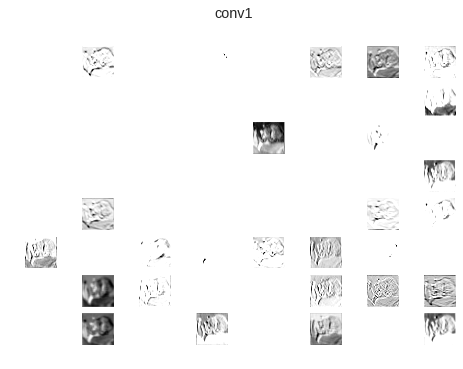

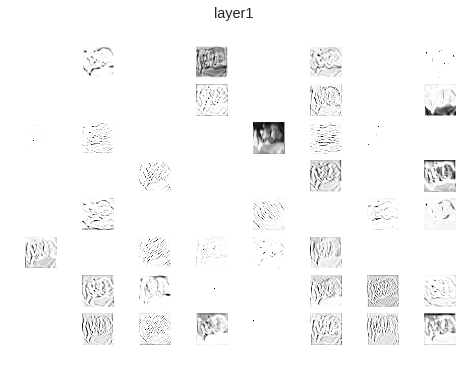

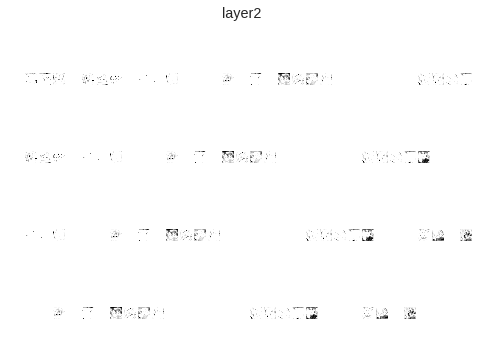

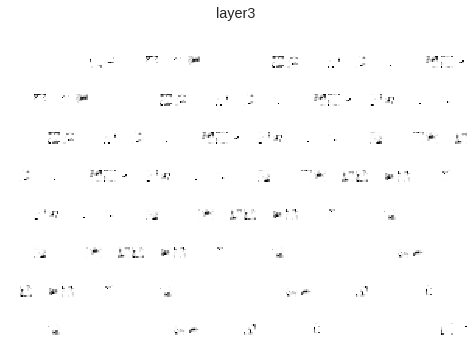

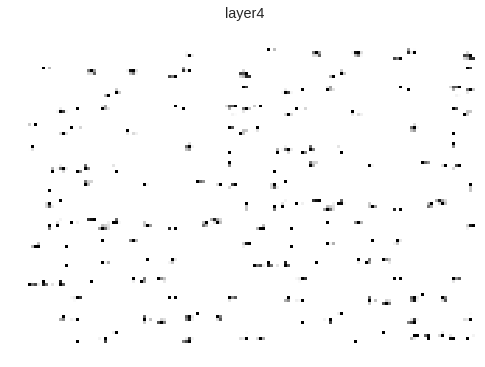

In [0]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')

**=============== END OF CW2 ===============**